Calculating the curve of growth for different ions based on different b values

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pint

In [128]:
ureg = pint.UnitRegistry()
c = 3e8 * ureg.m / ureg.s


In [129]:
def tau_0(N, f, wavelength, b): #Draine, Eq. 9.10
    return 0.7580 * (N/(1e13 *ureg.cm**(-2))) * (f/0.4164) * (wavelength/1215.7*ureg.angstrom) * ((10*ureg.km/ureg.s)/b)

def W_approx (b, tau_0, gamma, wavelength): #Draine Eq. 9.27
    #tau_0 = tau_0.magnitude
    if tau_0 < 1.253933:
        W = np.sqrt(np.pi)
    else:
        W = np.sqrt(((2*b)/c)**2) * np.log(tau_0/np.log(2)) + (b/c) * ((gamma*wavelength)/c) * ((tau_0 - 1.253933)/np.sqrt(np.pi))
    return wavelength * W

In [130]:
#defining wavelength, oscillator strength, and gamma for Fe II 2382, Fe II 2249, and C II 1334
wavelength = np.array([2382.7642, 2249.8768, 1334.5323]) * ureg.angstrom
f = np.array([0.320, 0.00182, 0.12780])
gamma = np.array([3.13e8, 3.31e8, 2.88e8]) * ureg.s**(-1)
N_Fe = np.linspace(1e12,1e17,1000) *ureg.cm**2  
N_C = np.linspace(1e13,1e17,1000) *ureg.cm**2   
b = np.array([1, 2, 3, 5])

In [131]:
def width_calc(b, N, f, wavelength, gamma):
    """
    N and b are arrays of column density and Doppler parameter values, respectively.
    f and wavelength are the oscillator strength and wavelength of the transition.
    """
    width = np.zeros((len(N), len(b)))
    for i in range(len(N)):
        for j in range(len(b)):
            tau = tau_0(N[i], f, wavelength, b[j])
            tau = tau.magnitude
            w = W_approx(b[j], tau, gamma, wavelength)
            width[i,j] = w.magnitude
    return width

In [132]:
width_F_1 = width_calc(b, N_Fe, f[0], wavelength[0], gamma[0])
width_F_2 = width_calc(b, N_Fe, f[1], wavelength[1], gamma[1])
width_C = width_calc(b, N_C, f[2], wavelength[2], gamma[2])

In [135]:
def plot_curve_of_growth(N, width, b):
    N = N.magnitude
    plt.figure()
    for i in range(len(b)):
        #plt.plot(np.log10(N), np.log10(width[:,i]), label = 'b = {}'.format(b[i]))
        plt.plot(N, width[:,i], label = 'b = {}'.format(b[i]))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Column Density (cm$^{-2}$)')
    plt.ylabel('Equivalent Width (Angstrom)')
    plt.legend()
    plt.show()

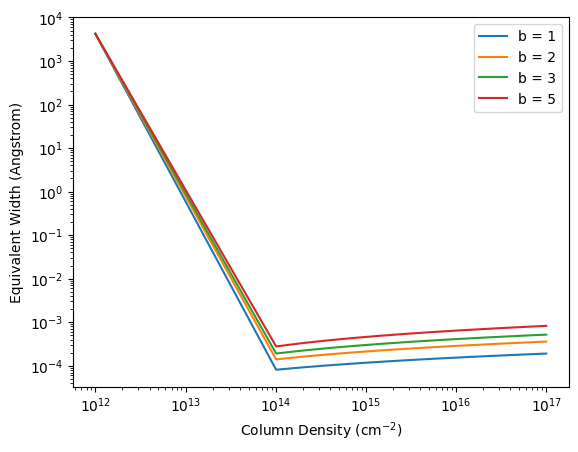

In [136]:
plot_curve_of_growth(N_Fe, width_F_1, b)

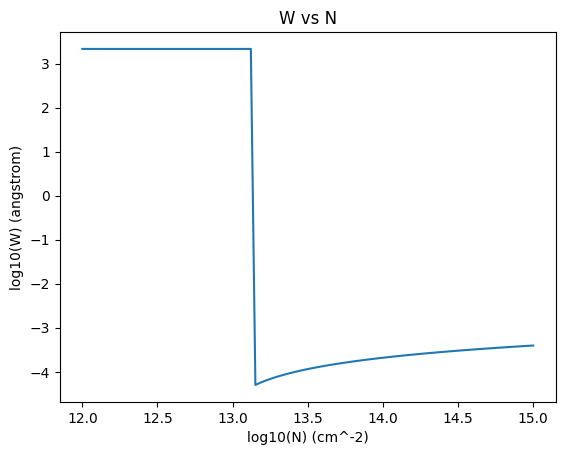

In [139]:
import numpy as np
import pint
import matplotlib.pyplot as plt

# Create a UnitRegistry
ureg = pint.UnitRegistry()

def tau_0(N, f, lamda, b):
    return 0.7580 * (N / (1e13 * ureg.cm**(-2))) * (f / 0.4164) * (lamda / (1215.7 * ureg.angstrom)) * ((10 * ureg.km / ureg.s) / b)

def W_approx(b, tau_0, gamma, wavelength): #Draine Eq. 9.27
    c = 3e8 * ureg.m / ureg.s  # Speed of light in m/s
    if tau_0 < 1.253933:
        W = np.sqrt(np.pi)
    else:
        W = np.sqrt(((2*b)/c)**2) * np.log(tau_0/np.log(2)) + (b/c) * ((gamma*wavelength)/c) * ((tau_0 - 1.253933)/np.sqrt(np.pi))
    return wavelength * W

# Example usage
f = 0.5
lamda = 1215.7 * ureg.angstrom
b = 10 * ureg.km / ureg.s
gamma = 1e8 * ureg.Hz

# Define a range of N values
N_values = np.logspace(12, 15, 100) * ureg.cm**(-2)

# Calculate W for each N value
W_values = []
for N in N_values:
    tau0 = tau_0(N, f, lamda, b)
    W = W_approx(b, tau0, gamma, lamda)
    W_values.append(W.magnitude)

# Plotting
plt.plot(np.log10(N_values.magnitude), np.log10(W_values))
plt.xlabel('log10(N) (cm^-2)')
plt.ylabel('log10(W) (angstrom)')
plt.title('W vs N')
plt.show()